In [1]:
import numpy as np
import matplotlib.pylab as plt

from mpl_toolkits.mplot3d import Axes3D

## 4.3.2 수치 미분의 예
$ y = 0.01 x^2 + 0.1 x$

0.1999999999990898


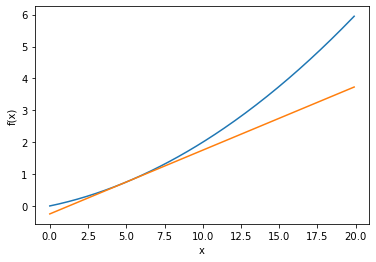

In [2]:
# gradient_1d.py
def function_1(x):
    return 0.01*x**2 + 0.1*x 


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)

## 4.4 기울기 (gradient)
$ f(x_0,x_1) = x_0^2 + x_1^2$

In [3]:
# gradient_2d.py
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

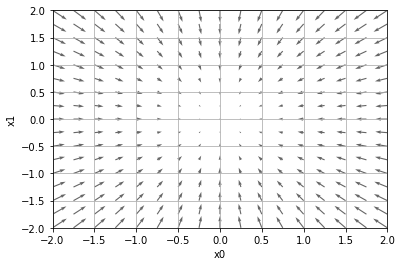

In [4]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
# plt.legend()
plt.draw()
plt.show()

## 4.4.1 경사법 (경사 하강법)

Text(0, 0.5, 'X1')

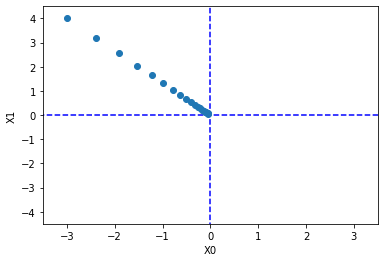

In [5]:
# gradient_method.py
# def function_2(x):
#     return x[0]**2 + x[1]**2

# from gradient_2d import numerical_gradient
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")

## 4.4.2 신경망에서의 기울기

In [6]:
# gradient_simplenet.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)    # w is dummy
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.37033237  0.01899971 -0.38933207]
 [ 0.55549855  0.02849956 -0.58399811]]


In [7]:
net.loss(x,t)

1.046646816613517

## 4.5.1 2층 신경망 클래스 구현하기

In [8]:
# two_layer_net.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [9]:
# 사용 예
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params

{'W1': array([[-0.00275169, -0.00453656, -0.01143512, ..., -0.01104538,
          0.00710536, -0.00229643],
        [-0.0028879 ,  0.01096067,  0.01094405, ..., -0.00227957,
         -0.00787546, -0.00566537],
        [ 0.01807549, -0.01766433, -0.00062049, ..., -0.015412  ,
         -0.00911119, -0.01663774],
        ...,
        [-0.00523109, -0.00450059, -0.00541868, ..., -0.00317665,
         -0.00132707, -0.01065902],
        [-0.0050278 , -0.00604442,  0.02322356, ...,  0.00106597,
         -0.00069371, -0.0077758 ],
        [-0.00290601,  0.01024552, -0.00219319, ..., -0.02922491,
         -0.00566096,  0.00396702]]),
 'b1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

<BarContainer object of 10 artists>

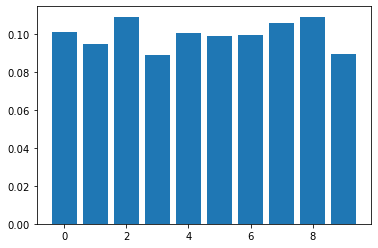

In [10]:
# forward prop
x = np.random.rand(100,784)
y = net.predict(x)

plt.bar(np.arange(0,10), y[0])
# plt.xticks(np.arange(0,10))

In [11]:
# calc gradient [SLOW!]
t = np.random.rand(100,10)
grads = net.numerical_gradient(x, t)
grads

{'W1': array([[ 1.55152202e-05, -2.46609622e-06,  6.69507627e-05, ...,
         -1.36162925e-05, -6.58934063e-05,  2.36318509e-04],
        [ 3.21972893e-06, -2.71704992e-05,  1.71322423e-05, ...,
         -6.68014977e-06, -8.07319323e-05,  1.94807637e-04],
        [ 6.29323149e-05, -9.67808056e-07, -1.09341647e-04, ...,
         -1.28058664e-04, -4.74770268e-05,  1.12604237e-04],
        ...,
        [-3.68908348e-05,  6.89952318e-06, -7.77787901e-05, ...,
          1.43437424e-04, -9.46466172e-05,  1.81623760e-04],
        [ 1.93839766e-05,  1.60271907e-05, -8.42449555e-05, ...,
         -4.92299335e-05, -8.63802163e-05,  1.54198307e-04],
        [-5.27449195e-07,  1.57738471e-04, -1.40816574e-04, ...,
          1.44535981e-04, -1.07301539e-04,  2.85860238e-04]]),
 'b1': array([ 4.58580529e-05,  3.85766552e-05, -8.34261304e-05, -5.94074256e-05,
         5.37836686e-05, -1.82142814e-04, -3.49825944e-04,  8.26447422e-05,
         2.03673047e-04,  1.78062203e-04, -4.56566074e-05,  3.966

## MNIST 데이터로 학습 (4.5.2 미니배치 학습 구현하기 / 4.5.3 시험 데이터로 평가하기)

In [12]:
# train_neuralnet.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.0993, 0.1032
train acc, test acc | 0.7802666666666667, 0.7838
train acc, test acc | 0.8757166666666667, 0.877
train acc, test acc | 0.8981666666666667, 0.9019
train acc, test acc | 0.9080666666666667, 0.9102
train acc, test acc | 0.9153333333333333, 0.9168
train acc, test acc | 0.9198166666666666, 0.9205
train acc, test acc | 0.9234166666666667, 0.924
train acc, test acc | 0.9269833333333334, 0.9278
train acc, test acc | 0.9295333333333333, 0.9295
train acc, test acc | 0.9324166666666667, 0.9328
train acc, test acc | 0.9349333333333333, 0.9348
train acc, test acc | 0.9366333333333333, 0.937
train acc, test acc | 0.9397, 0.9385
train acc, test acc | 0.9416166666666667, 0.94
train acc, test acc | 0.9432666666666667, 0.942
train acc, test acc | 0.9447833333333333, 0.9434


Text(0, 0.5, 'loss')

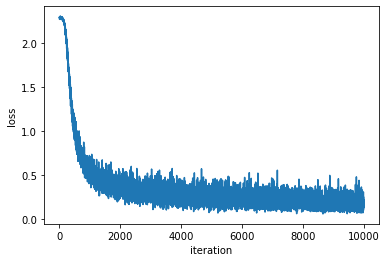

In [13]:
# 손실 함수
plt.plot(train_loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')

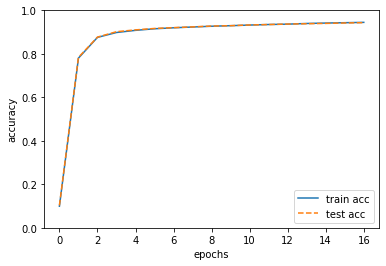

In [16]:
# 정확도 그래프
# markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()